In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()
import imutils


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 700,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )



In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:
MAX_RATIO = 15


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Collate1__Resized_inverted_2000_white_2.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

(41, 178, 3)
0
(41, 178, 3)
torch.Size([1, 96, 417])


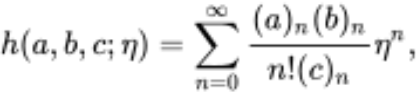

None

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [8]:
image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(116, 516, 3)
0
(116, 516, 3)
torch.Size([1, 96, 427])


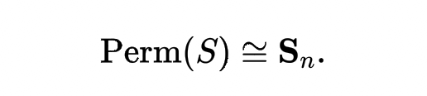

None

Predicted formula:
 <S> \mathrm { P e r m } \big ( S \big ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> \mathrm { P e r m } \big ( S \big ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [44]:
image_path= "Jupyter_Notebooks/test_photos/zarhin.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.5, fy=.5,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(152, 658, 3)
0
(152, 658, 3)
torch.Size([1, 96, 416])


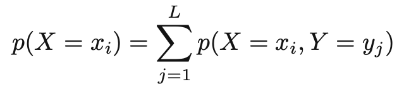

None

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [47]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.5, fy=.5,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(320, 1080, 3)
0
(320, 1080, 3)
torch.Size([1, 96, 324])


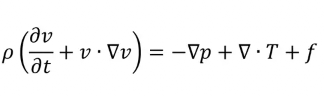

None

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + v \cdot \nabla _ { v } \right) = - \nabla _ { p } + \nabla \cdot T + f } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> \rho \left( \frac { \partial v } { \partial t } + v \cdot \nabla _ { v } \right) = - \nabla _ { p } + \nabla \cdot T + f } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [48]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.5, fy=.5,  interpolation=cv2.INTER_LINEAR)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]


print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(23, 57, 3)
0
(23, 57, 3)
torch.Size([1, 64, 159])


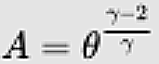

None

Predicted formula:
 <S> A = \theta ^ { \frac { \gamma - 2 } { \gamma } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> A = \theta ^ { \frac { \gamma - 2 } { \gamma } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [40]:
image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding_SMALL(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(200, 1424, 3)
0
(200, 1424, 3)
torch.Size([1, 96, 684])


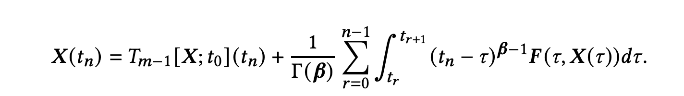

None

Predicted formula:
 <S> { \bf X } ( t _ { n } ) = T _ { m - 1 } [ { \bf X } ; t _ { 0 } ] ( t _ { n } ) \star \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { n - 1 } ( t _ { n } - \tau ) ^ { \prime - 1 } F ( \tau , { \bf X } ( r ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> { \bf X } ( t _ { n } ) = T _ { m - 1 } [ { \bf X } ; t _ { 0 } ] ( t _ { n } ) \star \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { n - 1 } ( t _ { n } - \tau ) ^ { \prime - 1 } F ( \tau , { \bf X } ( r ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [41]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.6, fy=.6,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(188, 1950, 3)
0
(188, 1950, 3)
torch.Size([1, 96, 996])


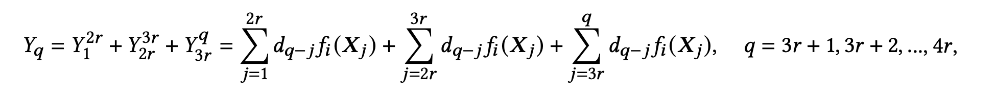

None

Predicted formula:
 <S> Y _ { q } \equiv Y _ { 1 } ^ { 2 r } + Y _ { 3 r } ^ { 3 r } \cdot Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j } f _ { t } ( { \bf X } _ { j } ) \star \sum _ { j = J r } ^ { 3 r } d _ { q - j } \xi ( { \bf X } _ { j } ) + \sum _ { j = j = p } ^ { q } d _ { q = 1 , 3 r


<IPython.core.display.Math object>

None
 <S> Y _ { q } \equiv Y _ { 1 } ^ { 2 r } + Y _ { 3 r } ^ { 3 r } \cdot Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j } f _ { t } ( { \bf X } _ { j } ) \star \sum _ { j = J r } ^ { 3 r } d _ { q - j } \xi ( { \bf X } _ { j } ) + \sum _ { j = j = p } ^ { q } d _ { q = 1 , 3 r


<IPython.core.display.Math object>

None


In [14]:
 
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_10.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.33, fy=.33,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(202, 1774, 3)
0
(202, 1774, 3)
torch.Size([1, 96, 843])


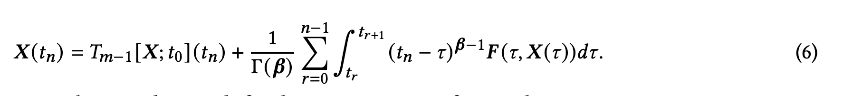

None

Predicted formula:
 <S> X ( t _ { n } ) \equiv T _ { m - 1 } [ { \bf X } ; _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n = 1 } \int _ { t _ { r } } ^ { n = 1 } \int _ { t _ { r } } ^ { r _ { r - 1 } } ( t _ { n } - r ) ^ { \rho - 1 } F ( \tau , { \cal X } ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> X ( t _ { n } ) \equiv T _ { m - 1 } [ { \bf X } ; _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n = 1 } \int _ { t _ { r } } ^ { n = 1 } \int _ { t _ { r } } ^ { r _ { r - 1 } } ( t _ { n } - r ) ^ { \rho - 1 } F ( \tau , { \cal X } ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [42]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(384, 812, 3)
0
(384, 812, 3)
torch.Size([1, 96, 203])


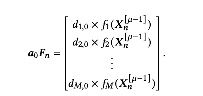

None

Predicted formula:
 <S> \begin{array} { c c } { \displaystyle { ( s _ { i j , s , j , ( N ) } \\ { \displaystyle ( i _ { i j , j , j , j , ( N ) } , ( N _ { 3 } ( n ) } \\ { 0 _ { i } , 2 , ( k ) , j , i ( N ) } \\ { \displaystyle { ( i _ { i } , 2 } , ( k _ { j , k } ^ { n - 1 } ) } \\ { \displaystyle { ( i _ { i } , 2 } , 0 , i , k _ { i } ,


<IPython.core.display.Math object>

None
 <S> \begin{array} { c c } { \displaystyle { ( s _ { i j , s , j , ( N ) } \\ { \displaystyle ( i _ { i j , j , j , j , ( N ) } , ( N _ { 3 } ( n ) } \\ { 0 _ { i } , 2 , ( k ) , j , i ( N ) } \\ { \displaystyle { ( i _ { i } , 2 } , ( k _ { j , k } ^ { n - 1 } ) } \\ { \displaystyle { ( i _ { i } , 2 } , 0 , i , k _ { i } ,


<IPython.core.display.Math object>

None


In [16]:
image_path=  "Jupyter_Notebooks/test_photos/Screen Shot_11.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(224, 1020, 3)
0
(224, 1020, 3)
torch.Size([1, 96, 437])


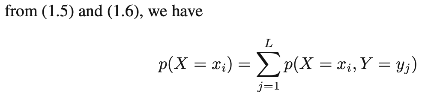

None

Predicted formula:
 <S> \begin{array} { c c c c c } { \mathrm { \small ~ f o m ( 1 ) , N ~ a e l , 3 ) . w e h v e } } \\ { \eta ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } \wp ( X = x _ { i } , Y = y _ { j } \rangle = y _ { j } ^ { l } \wp ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
 <S> \begin{array} { c c c c c } { \mathrm { \small ~ f o m ( 1 ) , N ~ a e l , 3 ) . w e h v e } } \\ { \eta ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } \wp ( X = x _ { i } , Y = y _ { j } \rangle = y _ { j } ^ { l } \wp ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [17]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_2.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

(100, 600, 3)
0
(100, 600, 3)
torch.Size([1, 96, 576])


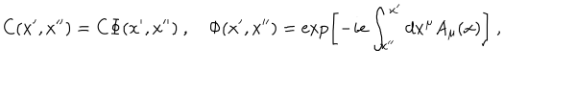

None

Predicted formula:
 <S> \begin{array} { c } { \zeta _ { N } ^ { \prime } , \vec { N } ^ { \star } ) = \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,


<IPython.core.display.Math object>

None
 <S> \begin{array} { c } { \zeta _ { N } ^ { \prime } , \vec { N } ^ { \star } ) = \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,


<IPython.core.display.Math object>

None


In [18]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_18.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

152 658 3
76
torch.Size([1, 96, 416])


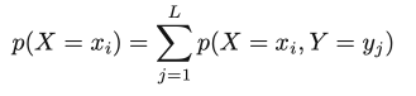

None

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , \, Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [19]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//2
w_new = w//2
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_LINEAR)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



#padded_images = torch.zeros(( 1, h, w))
#padded_images[ :,  :  h,  :  w] = image_tensor

#print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

41 178 3
64
torch.Size([1, 96, 384])


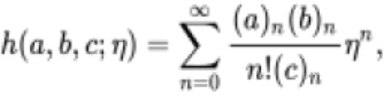

None


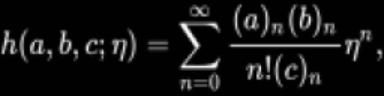

None

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [20]:
image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = 64
w_new = int(h_new*ratio)
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

320 1080 3
106
torch.Size([1, 96, 326])


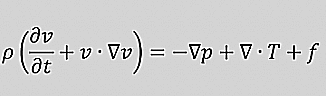

None


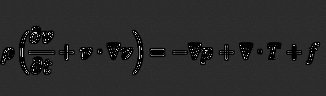

None

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial \phi } + v \cdot \nabla v \right) = - \nabla _ { p } + \nabla \cdot T + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [21]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//3
w_new = w//3
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_LINEAR)

image_tensor = Image_Transforms.train_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

None
64
torch.Size([1, 96, 192])


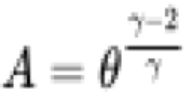

None

Predicted formula:
 <S> A = \theta ^ { \frac { \gamma - 2 } { \gamma } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [22]:
image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
print(display(transform(image)))


h, w, c = image.shape
ratio = int(w/h)
h_new  = 64
w_new = int(h_new*ratio)
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

384 812 3
192
torch.Size([1, 96, 203])


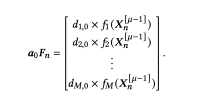

None


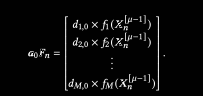

None

Predicted formula:
 <S> \begin{array} { c c } { \displaystyle { d _ { i n s } , 2 , ( N _ { 0 } , ( N ) } \\ { 0 , 2 , ( N _ { 0 } , ( N ) } \\ { 0 _ { i } , 2 , ( N _ { 0 } , m ^ { m } ) } \\ { 0 _ { i } , 2 , ( N _ { 0 } , i ( N ) } } \\ { 0 _ { i } , 2 } , ( N _ { 0 } , i , i , i , i , i , i , i , N } ^ {


<IPython.core.display.Math object>

None


In [23]:
image_path=  "Jupyter_Notebooks/test_photos/Screen Shot_11.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//2
w_new = w//2
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

200 1424 3
100
torch.Size([1, 96, 684])


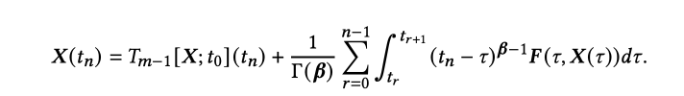

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 1 } { \bf P } ; t _ { 0 } , l _ { 0 } ( t _ { n } ) + \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { \prime _ { n + 1 } ( t _ { n } - \tau ) ^ { \prime - 1 } F ( \tau , { \bf X } ( r ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [24]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//2
w_new = w//2
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



#padded_images = torch.zeros(( 1, h, w))
#padded_images[ :,  :  h,  :  w] = image_tensor

#print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

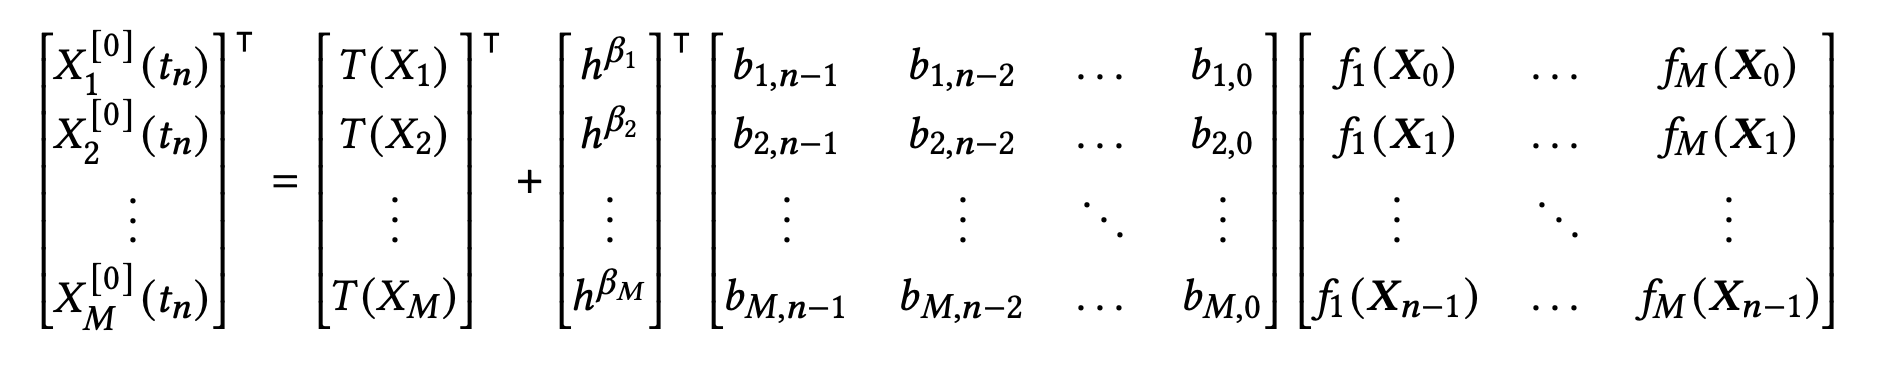

None
torch.Size([1, 96, 466])


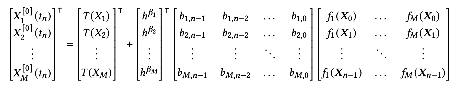

None

Predicted formula:
 <S> \begin{array} { c c c c c c c c c c c c c c c } { i ( n ) } & { ( n ) } & { ( n ) } & { 0 } & { 0 } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { \delta ( \alpha ( \chi ) } & { } & { } & { } & { \delta , \chi _ { 0 } } \\ { 0


<IPython.core.display.Math object>

None


In [25]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_12.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
print(display(transform(image)))


h, w, c = image.shape


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

202 1774 3
torch.Size([1, 96, 843])


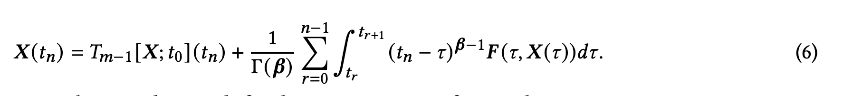

None


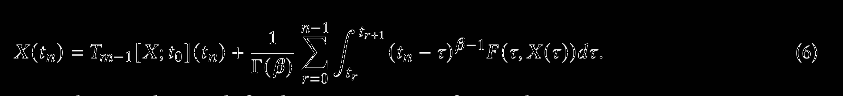

None

Predicted formula:
 <S> X ( t _ { n } ) \equiv T _ { m - 1 } [ { \bf X } ; _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n = 1 } \int _ { t _ { r } } ^ { n = 1 } \int _ { t _ { r } } ^ { r _ { r - 1 } } ( t _ { n } - r ) ^ { \rho - 1 } F ( \tau , { \cal X } ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [26]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

#ratio = int(w/h)
#h_new  = 64
#w_new = int(h_new*ratio)
#print(h_new)
#image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

188 1950 3
100
torch.Size([1, 96, 960])


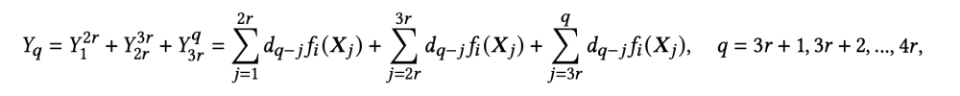

None


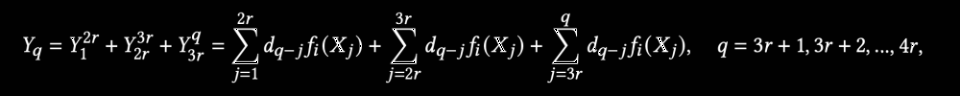

None

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } \cdot Y _ { 2 r } ^ { 3 r } \cdot Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j f l } ( { \bf X } _ { j } ) \star \sum _ { j = J r } ^ { 3 r } d _ { q - j } \xi _ { j } ) * \sum _ { j = 3 r } ^ { q } d _ { q - j } \xi _ { j } ) , \quad q = 3


<IPython.core.display.Math object>

None


In [27]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_10.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = 100
w_new = int(h_new*ratio)
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

202 1774 3
torch.Size([1, 96, 843])


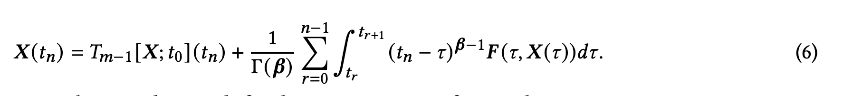

None

Predicted formula:
 <S> X ( t _ { n } ) \equiv T _ { m - 1 } [ { \bf X } ; _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n = 1 } \int _ { t _ { r } } ^ { n = 1 } \int _ { t _ { r } } ^ { r _ { r - 1 } } ( t _ { n } - r ) ^ { \rho - 1 } F ( \tau , { \cal X } ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [28]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

#ratio = int(w/h)
#h_new  = 100
#w_new = h_new*ratio
#print(h_new)
#image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_LINEAR)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
#c, h, w = image_tensor.shape



#padded_images = torch.zeros(( 1, h, w))
#padded_images[ :,  :  h,  :  w] = image_tensor

#print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(1774, 202)
(887, 101)


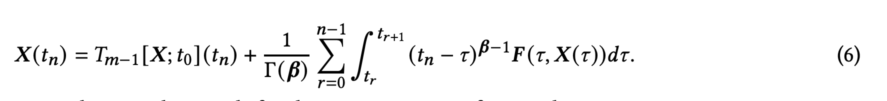

None


In [29]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image.size
print(image.size)
w_new = w//2
h_new = h//2
image = image.resize((w_new, h_new), resample=Image.Resampling.BILINEAR)
print(image.size)
print(display(image)) 


(202, 1774, 3)
(101, 887, 3)
torch.Size([1, 96, 843])


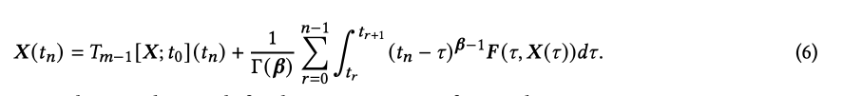

None


In [30]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
image = cv2.resize(image, (0,0), fx=0.5, fy=0.5,interpolation=cv2.INTER_LINEAR)
print(image.shape)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

(23, 57, 3)
(69, 171, 3)
torch.Size([1, 96, 238])


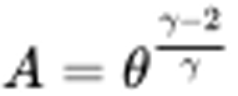

None


In [31]:
image_path= image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
image = cv2.resize(image, (0,0), fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
print(image.shape)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor)))

In [32]:
import torchvision

In [33]:
from torchvision import models
from torch import nn

In [34]:
resnet = models.resnet34(pretrained=False)

In [35]:
backbone1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
)

backbone2 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
    resnet.layer4
)

In [36]:
backbone1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con